# JunGrad Quick Start Guide

Welcome to **JunGrad**, a robust N-D autograd library! This tutorial will walk you through the key features step by step.

**What you'll learn:**
- Creating and manipulating N-D tensors
- Automatic differentiation and gradient computation
- Building neural networks with Sequential layers
- Training models with optimizers (SGD, Adam, AdamW, RMSProp)
- Advanced layers (Conv1d, LayerNorm, Embedding, Dropout)
- Activation functions and functional API
- Classification with cross-entropy loss
- Learning rate schedulers (StepLR, CosineLR, OneCycleLR)
- Gradient clipping for stable training
- Performance optimization with no_grad()
- Visualizing computation graphs with Graphviz
- Profiling operations for performance analysis
- Gradient checking for verification
- Complete training examples with best practices

## 1. Creating Tensors

Tensors are the fundamental building blocks of JunGrad. They're **N-dimensional arrays** (like NumPy) that support **automatic differentiation**. Unlike scalar-only autograd libraries, JunGrad works with tensors of any shape from the start.

In [1]:
from jungrad import tensor, randn, zeros, ones

# Create tensors from lists
a = tensor([1.0, 2.0, 3.0])
print(f"Tensor from list: {a}")
print(f"Shape: {a.shape}, Dtype: {a.dtype}")

# Create tensors with gradients enabled (for autograd)
b = tensor([4.0, 5.0, 6.0], requires_grad=True)
print(f"\nTensor with gradients: {b}")
print(f"Requires grad: {b.requires_grad}")

# Create random tensors
x = randn(3, 4)  # 3x4 random tensor
print(f"\nRandom tensor shape: {x.shape}")
print(f"Random tensor data: {x.data}")

# Create zeros and ones
z = zeros((2, 3))
o = ones((2, 3))
print(f"\nZeros:\n{z.data}")
print(f"Ones:\n{o.data}")

Tensor from list: Tensor(shape=(3,), dtype=float64, requires_grad=False)
Shape: (3,), Dtype: float64

Tensor with gradients: Tensor(shape=(3,), dtype=float64, requires_grad=True, grad=False)
Requires grad: True

Random tensor shape: (3, 4)
Random tensor data: [[-0.3042066   0.12919545  0.8236847   1.1874889 ]
 [ 2.3938217   1.3767868  -0.19361019 -1.4600362 ]
 [ 1.7085946  -0.9970839   0.36166227  0.01770661]]

Zeros:
[[0. 0. 0.]
 [0. 0. 0.]]
Ones:
[[1. 1. 1.]
 [1. 1. 1.]]


## 2. Automatic Differentiation

When you perform operations on tensors with `requires_grad=True`, it **automatically builds a computation graph**. Later, calling `.backward()` computes gradients for all tensors that contributed to the result.

Let's trace through how those gradients were computed using the **chain rule**:

**Forward Pass:**
```
x = [2, 3]
y = [4, 5]
z = x * y = [8, 15]
w = z² = [64, 225]
result = sum(w) = 289
```

**Backward Pass (Chain Rule):**

1. **From `result` to `w` (sum operation):**
   - The gradient of `sum` is `[1, 1]` (broadcasted to input shape)
   - `∂result/∂w = [1, 1]`

2. **From `w` to `z` (power operation: z²):**
   - For `w = z²`, the derivative is `2z = 2 × [8, 15] = [16, 30]`
   - By chain rule: `∂result/∂z = ∂result/∂w × ∂w/∂z = [1, 1] × [16, 30] = [16, 30]`

3. **From `z` to `x` and `y` (multiplication: x * y):**
   - For `z = x * y`:
     - `∂z/∂x = y = [4, 5]`
     - `∂z/∂y = x = [2, 3]`
   - By chain rule:
     - `∂result/∂x = ∂result/∂z × ∂z/∂x = [16, 30] × [4, 5] = [64, 150]`
     - `∂result/∂y = ∂result/∂z × ∂z/∂y = [16, 30] × [2, 3] = [32, 90]`

In [2]:
from jungrad import tensor

# Create tensors with gradient tracking
x = tensor([2.0, 3.0], requires_grad=True)
y = tensor([4.0, 5.0], requires_grad=True)

# Build a computation graph
z = x * y      # Element-wise multiplication
w = z ** 2     # Square each element
result = w.sum()  # Sum to scalar

print("Computing: result = sum((x * y)^2)")
print(f"x = {x.data}")
print(f"y = {y.data}")
print(f"z = x * y = {z.data}")
print(f"w = z^2 = {w.data}")
print(f"result = {result.item()}")

# Compute gradients with one call!
result.backward()

print(f"\nGradients computed automatically:")
print(f"∂result/∂x = {x.grad}")
print(f"∂result/∂y = {y.grad}")
print("\nThese gradients tell us how much 'result' changes when we change x or y")

Computing: result = sum((x * y)^2)
x = [2. 3.]
y = [4. 5.]
z = x * y = [ 8. 15.]
w = z^2 = [ 64. 225.]
result = 289.0

Gradients computed automatically:
∂result/∂x = [ 64. 150.]
∂result/∂y = [32. 90.]

These gradients tell us how much 'result' changes when we change x or y


## 3. Broadcasting and Matrix Operations

JunGrad handles **broadcasting** automatically (like NumPy), making it easy to work with different tensor shapes. The `@` operator performs matrix multiplication.

In [3]:
from jungrad import randn

# Broadcasting: (3, 4) + (4,) = (3, 4)
# The smaller tensor is automatically "stretched" to match
x = randn(3, 4, requires_grad=True)
y = randn(4, requires_grad=True)
z = x + y  # Broadcasting happens automatically

print("Broadcasting example:")
print(f"x.shape = {x.shape}  (3×4 matrix)")
print(f"y.shape = {y.shape}     (4-element vector)")
print(f"z.shape = {z.shape}  (automatically broadcast to 3×4)")
print(f"\nThe vector y is added to each row of x!")

# Matrix multiplication using @ operator
w = randn(4, 5, requires_grad=True)
out = x @ w

print(f"\nMatrix multiplication:")
print(f"x @ w: {x.shape} @ {w.shape} = {out.shape}")
print("Perfect for neural network layers")

Broadcasting example:
x.shape = (3, 4)  (3×4 matrix)
y.shape = (4,)     (4-element vector)
z.shape = (3, 4)  (automatically broadcast to 3×4)

The vector y is added to each row of x!

Matrix multiplication:
x @ w: (3, 4) @ (4, 5) = (3, 5)
Perfect for neural network layers


## 4. Building Neural Networks

Now let's build a real neural network! We'll use `Sequential` to stack layers together.

In [8]:
from jungrad import randn
from jungrad.nn import Linear, ReLU, Sequential
from jungrad.losses import mse_loss

# Build a 2-layer MLP: 10 → 20 → 1
model = Sequential(
    Linear(10, 20),  # First layer: 10 inputs → 20 outputs
    ReLU(),          # Activation function
    Linear(20, 1),   # Output layer: 20 → 1
)

print("🏗️Model architecture:")
print(model)
print(f"\nTotal trainable parameters: {sum(p.data.size for p in model.parameters())}")

# Create some dummy data (batch of 32 samples)
batch_size = 32
x = randn(batch_size, 10)  # 32 samples, 10 features each
y = randn(batch_size, 1)   # 32 targets

# Forward pass: compute predictions and loss
pred = model(x)
loss = mse_loss(pred, y)

print(f"\nForward pass:")
print(f"Input:  {x.shape}")
print(f"Output: {pred.shape}")
print(f"Loss:   {loss.item():.4f}")

🏗️Model architecture:

Total trainable parameters: 241

Forward pass:
Input:  (32, 10)
Output: (32, 1)
Loss:   80.2078


## 5. Training with Optimizers

Now let's train the model. We'll use an optimizer to update the weights based on the gradients.

In [9]:
from jungrad.optim import SGD
from jungrad.losses import mse_loss

# Initialize optimizer with learning rate and momentum
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training step:
# 1. Compute gradients
loss.backward()

# 2. Update weights using the optimizer
optimizer.step()

# 3. Zero gradients for the next iteration
optimizer.zero_grad()

print("Training step completed!")
print("Weights have been updated using gradient descent with momentum.")

# Forward again to see the new loss
pred_new = model(x)
loss_new = mse_loss(pred_new, y)
print(f"\nLoss after one step: {loss_new.item():.4f} (was {loss.item():.4f})")

Training step completed!
Weights have been updated using gradient descent with momentum.

Loss after one step: 33.0400 (was 80.2078)


## 6. Complete Training Loop

Let's put it all together and train a small model for multiple epochs:

In [6]:
from jungrad import randn
from jungrad.nn import Linear, Sequential, ReLU
from jungrad.optim import Adam
from jungrad.losses import mse_loss
import numpy as np

# 2-layer MLP: 10 → 20 → 1
model = Sequential(
    Linear(10, 20),  # First layer: 10 inputs → 20 outputs
    ReLU(),          # Activation function
    Linear(20, 1),   # Output layer: 20 → 1
)

# Generate synthetic data (y ≈ 2*x[0] + noise)
# Use numpy for data generation since it's synthetic
x_train = randn(100, 10)
x_train_np = x_train.data  # Get numpy array for indexing
y_train = tensor(x_train_np[:, 0:1] * 2.0 + np.random.randn(100, 1) * 0.1)

# Adam optimizer (adaptive learning rate)
optimizer = Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
print("🚂 Training...")
for epoch in range(num_epochs):
    # Forward pass
    pred = model(x_train)
    loss = mse_loss(pred, y_train)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    optimizer.zero_grad()

    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:2d}/{num_epochs}, Loss: {loss.item():.4f}")

print("\n✅ Training complete! The model learned to approximate y ≈ 2*x[0]")

🚂 Training...
Epoch  5/100, Loss: 45.6595
Epoch 10/100, Loss: 29.4923
Epoch 15/100, Loss: 19.8203
Epoch 20/100, Loss: 14.2230
Epoch 25/100, Loss: 10.9981
Epoch 30/100, Loss: 8.9633
Epoch 35/100, Loss: 7.5162
Epoch 40/100, Loss: 6.2952
Epoch 45/100, Loss: 5.2331
Epoch 50/100, Loss: 4.3759
Epoch 55/100, Loss: 3.7146
Epoch 60/100, Loss: 3.2143
Epoch 65/100, Loss: 2.8222
Epoch 70/100, Loss: 2.4977
Epoch 75/100, Loss: 2.2216
Epoch 80/100, Loss: 1.9906
Epoch 85/100, Loss: 1.7962
Epoch 90/100, Loss: 1.6284
Epoch 95/100, Loss: 1.4836
Epoch 100/100, Loss: 1.3609

✅ Training complete! The model learned to approximate y ≈ 2*x[0]


## 7. Advanced Layers

JunGrad includes many specialized layers. Here are a few highlights:

In [7]:
from jungrad import randn
from jungrad.nn import Conv1d, LayerNorm, Embedding
import numpy as np

# 1D Convolution for sequence/time-series data
print("🔲 Conv1d - 1D Convolution")
conv = Conv1d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
x_conv = randn(8, 3, 32)  # (batch, channels, length)
out_conv = conv(x_conv)
print(f"Input:  {x_conv.shape}")
print(f"Output: {out_conv.shape}")

# Layer Normalization (used in Transformers!)
print("\n📊 LayerNorm - Normalizes across feature dimension")
ln = LayerNorm(normalized_shape=128, eps=1e-5, affine=True)
x_ln = randn(4, 10, 128)  # (batch, seq_len, features)
out_ln = ln(x_ln)
print(f"Input:  {x_ln.shape}")
print(f"Output: {out_ln.shape}")
print(f"Before Normalized: mean={x_ln.data.mean():.3f}, std={x_ln.data.std():.3f}")
print(f"After Normalized: mean={out_ln.data.mean():.3f}, std={out_ln.data.std():.3f}")

# Embedding layer (for categorical/token data)
print("\n🔢 Embedding - Maps integers to dense vectors")
embed = Embedding(num_embeddings=1000, embedding_dim=128)
indices = np.array([[0, 1, 2], [3, 4, 5]])  # (batch, seq_len)
out_embed = embed(indices)
print(f"Indices: {indices.shape} (token IDs)")
print(f"Output:  {out_embed.shape} (dense embeddings)")

🔲 Conv1d - 1D Convolution
Input:  (8, 3, 32)
Output: (8, 16, 32)

📊 LayerNorm - Normalizes across feature dimension
Input:  (4, 10, 128)
Output: (4, 10, 128)
Before Normalized: mean=0.019, std=0.990
After Normalized: mean=-0.000, std=1.000

🔢 Embedding - Maps integers to dense vectors
Indices: (2, 3) (token IDs)
Output:  (2, 3, 128) (dense embeddings)


## 8. Activation Functions

Let's see some activation functions available in the functional API:

In [8]:
from jungrad import tensor
from jungrad.functional import relu, tanh, sigmoid, gelu, softmax

x = tensor([-2.0, -1.0, 0.0, 1.0, 2.0])

print("Input:", x.data)
print(f"ReLU:    {relu(x).data}")
print(f"Tanh:    {tanh(x).data}")
print(f"Sigmoid: {sigmoid(x).data}")
print(f"GELU:    {gelu(x).data}")

# Softmax (normalizes to probability distribution)
logits = tensor([1.0, 2.0, 3.0])
probs = softmax(logits)
print(f"\nSoftmax example:")
print(f"Logits:  {logits.data}")
print(f"Softmax: {probs.data} (sums to {probs.data.sum():.3f})")

Input: [-2. -1.  0.  1.  2.]
ReLU:    [0. 0. 0. 1. 2.]
Tanh:    [-0.96402758 -0.76159416  0.          0.76159416  0.96402758]
Sigmoid: [0.11920292 0.26894142 0.5        0.73105858 0.88079708]
GELU:    [-0.04540231 -0.15880801  0.          0.84119199  1.95459769]

Softmax example:
Logits:  [1. 2. 3.]
Softmax: [0.09003057 0.24472847 0.66524096] (sums to 1.000)


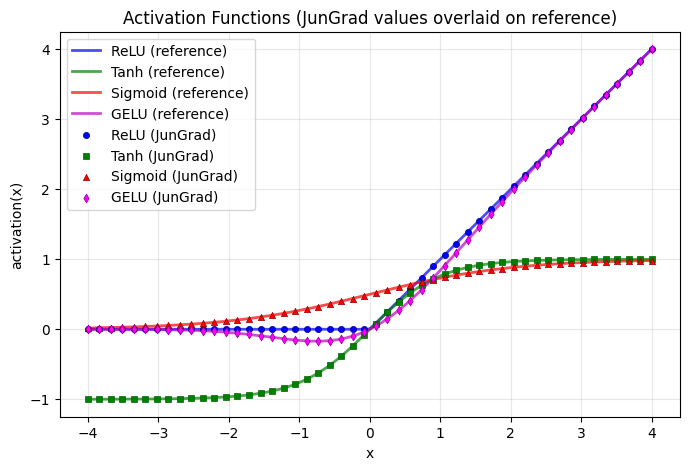

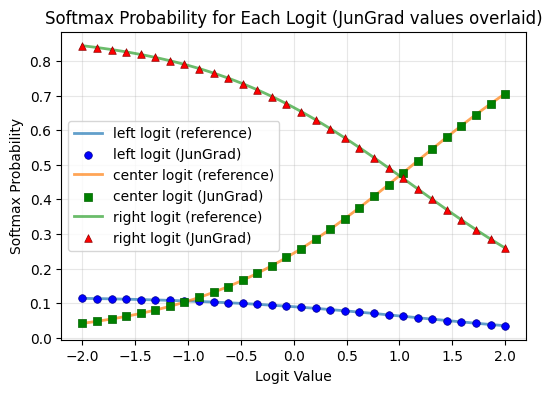

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Plot common activation functions
x_plot = np.linspace(-4, 4, 200)
# Evaluate each activation on numpy for visualization (reference)
relu_y = np.maximum(0, x_plot)
tanh_y = np.tanh(x_plot)
sigmoid_y = 1 / (1 + np.exp(-x_plot))
gelu_y = 0.5 * x_plot * (1 + np.tanh(np.sqrt(2 / np.pi) * (x_plot + 0.044715 * x_plot ** 3)))

# Compute using JunGrad for verification (sample points)
x_sample = np.linspace(-4, 4, 50)  # Fewer points for faster computation
x_tensor = tensor(x_sample)
relu_jungrad = relu(x_tensor).data
tanh_jungrad = tanh(x_tensor).data
sigmoid_jungrad = sigmoid(x_tensor).data
gelu_jungrad = gelu(x_tensor).data

plt.figure(figsize=(8, 5))
# Plot reference lines
plt.plot(x_plot, relu_y, 'b-', label="ReLU (reference)", alpha=0.7, linewidth=2)
plt.plot(x_plot, tanh_y, 'g-', label="Tanh (reference)", alpha=0.7, linewidth=2)
plt.plot(x_plot, sigmoid_y, 'r-', label="Sigmoid (reference)", alpha=0.7, linewidth=2)
plt.plot(x_plot, gelu_y, 'm-', label="GELU (reference)", alpha=0.7, linewidth=2)

# Overlay JunGrad computed values
plt.scatter(x_sample, relu_jungrad, c='blue', marker='o', s=20, label="ReLU (JunGrad)", zorder=5, edgecolors='darkblue', linewidths=0.5)
plt.scatter(x_sample, tanh_jungrad, c='green', marker='s', s=20, label="Tanh (JunGrad)", zorder=5, edgecolors='darkgreen', linewidths=0.5)
plt.scatter(x_sample, sigmoid_jungrad, c='red', marker='^', s=20, label="Sigmoid (JunGrad)", zorder=5, edgecolors='darkred', linewidths=0.5)
plt.scatter(x_sample, gelu_jungrad, c='magenta', marker='d', s=20, label="GELU (JunGrad)", zorder=5, edgecolors='darkmagenta', linewidths=0.5)

plt.title("Activation Functions (JunGrad values overlaid on reference)")
plt.xlabel("x")
plt.ylabel("activation(x)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Softmax visualization
plt.figure(figsize=(6, 4))
logits_grid = np.linspace(-2, 2, 100)
# Show how softmax outputs change for each position in a vector of logits
softmax_mat = []
for i in range(len(logits_grid)):
    # Construct a batch of logits where a single element varies over grid, other elements are fixed (e.g., zero)
    logits_vecs = np.zeros((len(logits_grid), 3))
    logits_vecs[:, 1] = logits_grid  # Vary the center logit (arbitrary choice)
    logits_vecs[:, 0] = -1           # Fix other logits for visualization
    logits_vecs[:, 2] = 1

    # Softmax over last axis
    shifted = logits_vecs - np.max(logits_vecs, axis=1, keepdims=True)
    e = np.exp(shifted)
    softmax_vals = e / np.sum(e, axis=1, keepdims=True)
    softmax_mat.append(softmax_vals[:, 1])  # Track softmax value at center position

softmax_mat = np.array(softmax_mat).T  # shape: (len(logits_grid), len(logits_grid))

# Compute softmax using JunGrad for verification
logits_sample = np.linspace(-2, 2, 30)  # Fewer points for faster computation
jungrad_softmax_vals = []
for idx, label in zip([0, 1, 2], ["left logit", "center logit", "right logit"]):
    # Reference plot
    logits_vecs = np.stack([np.full_like(logits_grid, -1), logits_grid, np.full_like(logits_grid, 1)], axis=-1)
    shifted = logits_vecs - np.max(logits_vecs, axis=1, keepdims=True)
    e = np.exp(shifted)
    s = e / np.sum(e, axis=1, keepdims=True)
    plt.plot(logits_grid, s[:, idx], label=f"{label} (reference)", alpha=0.7, linewidth=2)

    # JunGrad computation for sample points
    logits_vecs_jungrad = np.stack([np.full_like(logits_sample, -1), logits_sample, np.full_like(logits_sample, 1)], axis=-1)
    softmax_jungrad = []
    for logit_vec in logits_vecs_jungrad:
        logit_tensor = tensor(logit_vec)
        prob = softmax(logit_tensor)
        softmax_jungrad.append(prob.data[idx])
    softmax_jungrad = np.array(softmax_jungrad)

    # Overlay JunGrad values
    markers = ['o', 's', '^']
    colors = ['blue', 'green', 'red']
    plt.scatter(logits_sample, softmax_jungrad, c=colors[idx], marker=markers[idx], s=30,
                label=f"{label} (JunGrad)", zorder=5, edgecolors=f'dark{colors[idx]}', linewidths=0.5)

plt.title("Softmax Probability for Each Logit (JunGrad values overlaid)")
plt.xlabel("Logit Value")
plt.ylabel("Softmax Probability")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## 9. Cross-Entropy Basics

This section introduces the basics of cross-entropy loss, a key function used for training classification models.


In [14]:
from jungrad import randn, tensor
from jungrad.losses import cross_entropy
import numpy as np

# Toy logits for a batch of 4 samples and 5 classes
logits = randn(4, 5, requires_grad=True)
labels = np.array([0, 3, 1, 4], dtype=np.int64)

print("Logits:\
", logits.data)
print("Labels:", labels)

loss = cross_entropy(logits, labels)
print(f"\nCross-entropy loss: {loss.item():.4f}")

# Backpropagate to see gradients flow through the logits
loss.backward()
print("Gradients wrt logits:\
", logits.grad)

# Quick sanity check: make the model slightly more confident in the right classes
boost = tensor(np.array([1.5, 0, 0, 0, 0]), requires_grad=False)
boosted_logits = tensor(logits.data + boost.data)
better_loss = cross_entropy(boosted_logits, labels)
print(f"Improved loss after boosting class 0: {better_loss.item():.4f}")


Logits: [[ 0.7295742  -0.01548518  2.3446424  -0.51932573 -1.1003093 ]
 [-0.00588682  0.11429812  0.47520638 -1.1227725   1.0226021 ]
 [-1.3646578  -0.08697378 -0.32073218 -0.25143287 -0.48167834]
 [-0.02630128 -0.3192105  -0.23370446 -0.69661295  1.6555154 ]]
Labels: [0 3 1 4]

Cross-entropy loss: 1.6784
Gradients wrt logits: [[-0.21402976  0.01707529  0.18086669  0.01031699  0.00577079]
 [ 0.03639179  0.04103922  0.05887618 -0.23808905  0.10178189]
 [ 0.0193935  -0.18040994  0.05508424  0.05903691  0.0468953 ]
 [ 0.02960106  0.02208505  0.02405654  0.0151424  -0.09088504]]
Improved loss after boosting class 0: 1.6535


## 10. Learning Rate Schedulers

Schedulers adjust the learning rate during training, which can improve convergence. JunGrad provides several schedulers.


In [10]:
from jungrad import randn
from jungrad.nn import Linear, Sequential
from jungrad.optim import SGD
from jungrad.sched import StepLR, CosineLR, OneCycleLR
from jungrad.losses import mse_loss

# Simple model
model = Sequential(Linear(5, 1))
optimizer = SGD(model.parameters(), lr=0.1)

# Example 1: StepLR - decay every N epochs
print("StepLR - Decay by factor every N steps")
scheduler_step = StepLR(optimizer, step_size=10, gamma=0.5)
print(f"Initial LR: {scheduler_step.get_lr():.4f}")
for i in range(3):
    scheduler_step.step()
    print(f"After step {i+1}: LR = {scheduler_step.get_lr():.4f}")

# Example 2: CosineLR - cosine annealing
print("\nCosineLR - Smooth cosine decay")
optimizer_cos = SGD(model.parameters(), lr=0.1)
scheduler_cos = CosineLR(optimizer_cos, T_max=20, eta_min=0.001)
print(f"Initial LR: {scheduler_cos.get_lr():.4f}")
for i in [0, 5, 10, 15, 20]:
    scheduler_cos.last_epoch = i
    scheduler_cos.step()
    print(f"Step {i}: LR = {scheduler_cos.get_lr():.4f}")

# Example 3: OneCycleLR - one-cycle policy (warmup + decay)
print("\nOneCycleLR - One-cycle policy with warmup")
optimizer_cycle = SGD(model.parameters(), lr=0.01)
scheduler_cycle = OneCycleLR(optimizer_cycle, max_lr=0.1, total_steps=20, pct_start=0.3)
print(f"Initial LR: {scheduler_cycle.get_lr():.4f}")
for i in [0, 3, 6, 10, 15, 20]:
    scheduler_cycle.last_epoch = i
    scheduler_cycle.step()
    print(f"Step {i}: LR = {scheduler_cycle.get_lr():.4f}")


StepLR - Decay by factor every N steps
Initial LR: 0.1000
After step 1: LR = 0.1000
After step 2: LR = 0.1000
After step 3: LR = 0.1000

CosineLR - Smooth cosine decay
Initial LR: 0.1000
Step 0: LR = 0.0994
Step 5: LR = 0.0796
Step 10: LR = 0.0428
Step 15: LR = 0.0105
Step 20: LR = 0.0016

OneCycleLR - One-cycle policy with warmup
Initial LR: 0.0040
Step 0: LR = 0.0200
Step 3: LR = 0.0680
Step 6: LR = 0.0987
Step 10: LR = 0.0717
Step 15: LR = 0.0188
Step 20: LR = 0.0013


## 11. Gradient Clipping

Gradient clipping prevents exploding gradients by capping gradient values.


In [15]:
from jungrad import randn
from jungrad.nn import Linear, Sequential
from jungrad.optim import Adam, clip_grad_norm_, clip_grad_value_
from jungrad.losses import mse_loss
import numpy as np

# Create a model
model = Sequential(Linear(10, 1))
optimizer = Adam(model.parameters(), lr=0.01)

# Generate data
x = randn(32, 10)
y = randn(32, 1)

# Forward and backward
pred = model(x)
loss = mse_loss(pred, y)
loss.backward()

# Check gradient norms before clipping
grad_norms = [np.linalg.norm(p.grad) for p in model.parameters() if p.grad is not None]
print(f"Gradient norms before clipping: {grad_norms}")

# Method 1: Clip by norm (scales gradients to have max norm)
max_norm = 1.0
total_norm = clip_grad_norm_(model.parameters(), max_norm=max_norm)
print(f"\nClipped by norm (max_norm={max_norm})")
print(f"Total norm before clipping: {total_norm:.4f}")
grad_norms_after = [np.linalg.norm(p.grad) for p in model.parameters() if p.grad is not None]
print(f"Gradient norms after clipping: {grad_norms_after}")

# Reset gradients for next example
loss.backward()

# Method 2: Clip by value (hard clamp)
clip_value = 0.5
clip_grad_value_(model.parameters(), clip_value=clip_value)
print(f"\nClipped by value (clip_value={clip_value})")
grad_max_after = [p.grad.max() for p in model.parameters() if p.grad is not None]
grad_min_after = [p.grad.min() for p in model.parameters() if p.grad is not None]
print(f"Gradient max after clipping: {grad_max_after}")
print(f"Gradient min after clipping: {grad_min_after}")
print("All gradients are now in range [-0.5, 0.5]")


Gradient norms before clipping: [np.float32(4.23965), np.float32(1.2150545)]

Clipped by norm (max_norm=1.0)
Total norm before clipping: 4.4103
Gradient norms after clipping: [np.float32(0.96130025), np.float32(0.27550206)]

Clipped by value (clip_value=0.5)
Gradient max after clipping: [np.float32(0.5), np.float32(0.5)]
Gradient min after clipping: [np.float32(-0.5), np.float32(0.5)]
All gradients are now in range [-0.5, 0.5]


## 12. no_grad Context Manager

Use `no_grad()` to disable gradient computation during inference. This saves memory and speeds up evaluation


In [16]:
from jungrad import randn, no_grad
from jungrad.nn import Linear, Sequential

model = Sequential(Linear(10, 1))
x = randn(32, 10)

# Without no_grad: builds computation graph (slower, uses more memory)
pred_with_grad = model(x)
print(f"With gradients: requires_grad={pred_with_grad.requires_grad}")

# With no_grad: no graph building (faster, less memory)
with no_grad():
    pred_no_grad = model(x)
    print(f"Without gradients: requires_grad={pred_no_grad.requires_grad}")

# After exiting the context, gradients are re-enabled
pred_after = model(x)
print(f"After context: requires_grad={pred_after.requires_grad}")


With gradients: requires_grad=True
Without gradients: requires_grad=False
After context: requires_grad=True


## 13. Visualizing Computation Graphs with Graphviz

JunGrad can export computation graphs to Graphviz DOT format for visualization. If you have the `graphviz` Python package installed, graphs will be rendered **inline in the notebook**! Otherwise, you can export to `.dot` files and visualize them externally.

**To enable inline visualization:**
- Install Python package: `pip install graphviz`
- Install system Graphviz: `brew install graphviz` (macOS) or `apt-get install graphviz` (Linux)


Computation Graph Visualization:


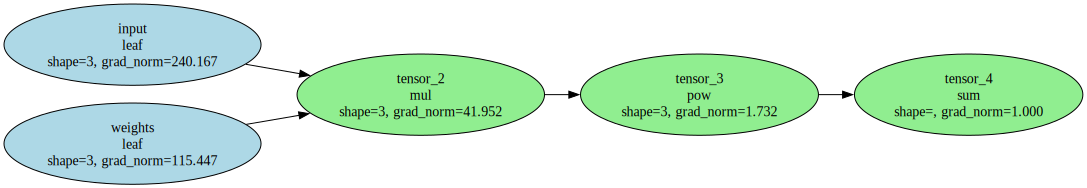

Graph rendered inline!

Graph also exported to 'computation_graph.dot'
You can visualize it online at: https://dreampuf.github.io/GraphvizOnline/

Neural Network Computation Graph:
Graph has 40 nodes


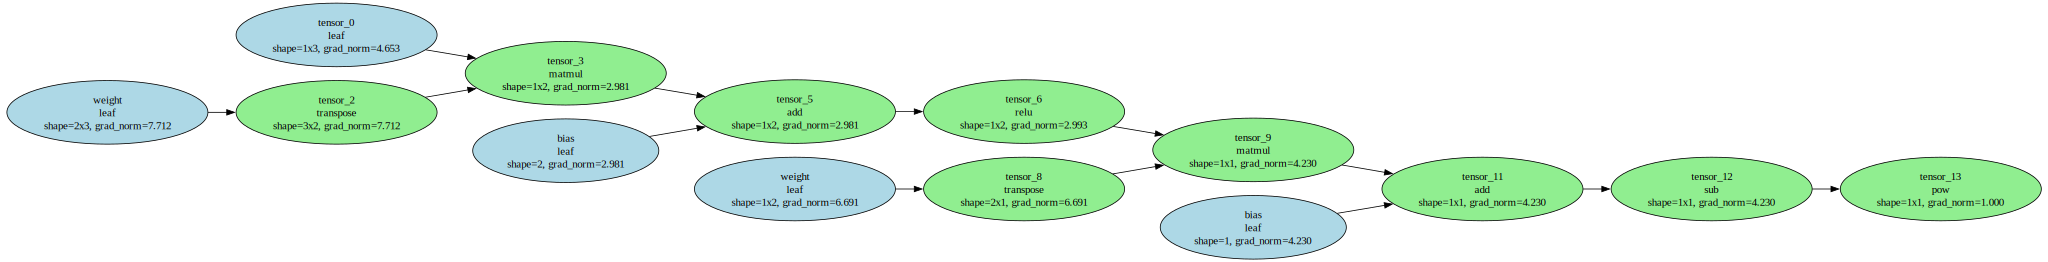

Neural network graph rendered inline!


In [17]:
from jungrad import tensor, randn
from jungrad.nn import Linear, Sequential, ReLU
from jungrad.graphviz import to_dot, export_graph
import graphviz
from IPython.display import display, SVG

# Check if system Graphviz binaries are available on PATH
try:
    test_graph = graphviz.Digraph()
    test_graph.node('test')
    test_graph.pipe(format='svg')  # This will fail if dot command not found
    GRAPHVIZ_SYSTEM_AVAILABLE = True
except Exception:
    GRAPHVIZ_SYSTEM_AVAILABLE = False

# Create a simple computation graph
x = tensor([1.0, 2.0, 3.0], requires_grad=True, name="input")
y = tensor([4.0, 5.0, 6.0], requires_grad=True, name="weights")

# Build a computation graph
z = x * y
w = z ** 2
result = w.sum()

# Compute gradients to populate grad fields
result.backward()

# Generate DOT string
dot_str = to_dot(result, max_nodes=20)

if GRAPHVIZ_SYSTEM_AVAILABLE:
    # Render graph inline in notebook
    print("Computation Graph Visualization:")
    try:
        # Create graphviz Source object
        graph = graphviz.Source(dot_str)
        # Render as SVG and display inline
        display(SVG(graph.pipe(format='svg')))
        print("Graph rendered inline!")
    except Exception as e:
        print(f"Could not render inline (error: {e})")
        print("\nTo fix this:")
        print("   1. Install system Graphviz:")
        print("      macOS: brew install graphviz")
        print("      Linux: sudo apt-get install graphviz")
        print("      Windows: Download from https://graphviz.org/download/")
        print("   2. Make sure 'dot' command is in your PATH")
        print("   3. Restart your Jupyter kernel")
        print("\nShowing DOT format instead:")
        print("=" * 60)
        print(dot_str[:500] + "...")
        print("=" * 60)
else:
    print("Computation Graph:")
    print("System Graphviz binaries are not available on PATH.")
    print("\nTo enable inline visualization:")
    print("   1. Install system Graphviz:")
    print("      macOS: brew install graphviz")
    print("      Linux: sudo apt-get install graphviz")
    print("      Windows: Download from https://graphviz.org/download/")
    print("   2. Make sure 'dot' command is in your PATH")
    print("   3. Restart your Jupyter kernel")
    print("\nShowing DOT format (you can copy this to https://dreampuf.github.io/GraphvizOnline/):")
    print("=" * 60)
    print(dot_str[:500] + "...")
    print("=" * 60)

# Export to file as backup
export_graph(result, "computation_graph.dot")
print("\nGraph also exported to 'computation_graph.dot'")
print("You can visualize it online at: https://dreampuf.github.io/GraphvizOnline/")

# Example with neural network
print("\n" + "=" * 60)
print("Neural Network Computation Graph:")
print("=" * 60)
model = Sequential(Linear(3, 2), ReLU(), Linear(2, 1))
x_nn = randn(1, 3, requires_grad=True)
out = model(x_nn)
loss = (out - tensor([[1.0]])) ** 2
loss.backward()

dot_nn = to_dot(loss, max_nodes=50)
print(f"Graph has {len(dot_nn.split('node')) - 1} nodes")

if GRAPHVIZ_SYSTEM_AVAILABLE:
    try:
        graph_nn = graphviz.Source(dot_nn)
        display(SVG(graph_nn.pipe(format='svg')))
        print("Neural network graph rendered inline!")
    except Exception as e:
        print(f"Could not render large graph inline: {e}")
        print("Try reducing max_nodes or use external visualization")
        print("   Online tool: https://dreampuf.github.io/GraphvizOnline/")
else:
    print("\n💡 Install system Graphviz to enable inline visualization!")
    print("   See instructions above.")


## 14. Profiling Operations

Use the profiler to measure how long different operations take. Great for performance optimization!


In [19]:
from jungrad import randn
from jungrad.nn import Linear, Sequential, ReLU
from jungrad.profiler import profile, get_profiler

model = Sequential(
    Linear(100, 200),
    ReLU(),
    Linear(200, 50),
    ReLU(),
    Linear(50, 10),
)

x = randn(32, 100)

# Profile different operations
profiler = get_profiler()

# Profile forward pass
with profile("forward_pass"):
    out = model(x)

# Profile backward pass
loss = (out ** 2).sum()
with profile("backward_pass"):
    loss.backward()

# Profile multiple forward passes
for i in range(5):
    with profile("forward_batch"):
        _ = model(x)

# Print profiling summary
print("Profiling Summary:")
print(profiler.summary())

# Reset profiler
profiler.reset()
print("\nProfiler reset. Ready for new measurements!")


Profiling Summary:
Profiling Summary:
Operation                      Count      Total Time (s)  Avg Time (ms)  
----------------------------------------------------------------------
backward_pass                  1          0.000241        0.2410         
forward_batch                  5          0.000300        0.0601         
forward_pass                   1          0.000205        0.2054         

Profiler reset. Ready for new measurements!


## 15. Gradient Checking

Verify your gradients are correct using finite differences. Essential when implementing custom operations!


In [20]:
from jungrad import tensor, randn
from jungrad.testing import gradcheck
from jungrad.ops import add, mul, exp

# Test a simple operation: f(x, y) = exp(x * y)
def test_func(x, y):
    return exp(mul(x, y))

# Create test inputs
x = randn(3, 4, requires_grad=True)
y = randn(3, 4, requires_grad=True)

# Run gradient check
print("🔍 Checking gradients for f(x, y) = exp(x * y)")
print("Comparing analytical gradients vs. numerical gradients...")
try:
    passed = gradcheck(test_func, (x, y), eps=1e-5, atol=1e-5, rtol=1e-3)
    if passed:
        print("Gradient check PASSED! Gradients are correct.")
    else:
        print("Gradient check FAILED! Check your implementation.")
except AssertionError as e:
    print(f"Gradient check failed: {e}")

# Test another function: f(x) = sum(x^2)
def test_func2(x):
    return (x ** 2).sum()

x2 = randn(5, requires_grad=True)
print("\nChecking gradients for f(x) = sum(x^2)")
try:
    passed = gradcheck(test_func2, (x2,), eps=1e-5)
    if passed:
        print("Gradient check PASSED!")
except AssertionError as e:
    print(f"Gradient check failed: {e}")


🔍 Checking gradients for f(x, y) = exp(x * y)
Comparing analytical gradients vs. numerical gradients...
Gradient check PASSED! Gradients are correct.

Checking gradients for f(x) = sum(x^2)
Gradient check PASSED!


## 16. End-to-End Classification Demo

Now that we've toured the individual building blocks—tensor operations, autograd, layers, optimizers, schedulers, and debugging tools—let's put everything together. This final walkthrough trains a multiclass classifier with realistic regularization, noisy data, learning-rate scheduling, gradient clipping, and rich evaluation metrics. It's the single place to see all the pieces working in concert.


> **Dependencies**
> 
> - `pip install "JunGrad[tutorial]"`
> - (Optional) `pip install "JunGrad[viz]"` if you plan to render Graphviz diagrams
> 
> These extras pull in datasets, scikit-learn, matplotlib, and related libraries used in the capstone demo below.


/Users/junkim/Documents/JunGrad/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.
Generating test split: 100%|██████████| 7532/7532 [00:00<00:00, 533919.75 examples/s]


Dataset: SetFit/20_newsgroups
  Train samples (used): 4000 / 11314
  Validation samples (used): 2000 / 7532
  Features (TF-IDF): 5000
  Classes: 20

Model Architecture:
  Parameters: 2,628,756
  Model: <jungrad.nn.layers.Sequential object at 0x11b3d06a0>

Starting Training...
  Epochs: 30
  Batch size: 64
  Learning rate: 0.0004
  Gradient clipping: 1.0
------------------------------------------------------------
Epoch   1/30 | Train Loss: 2.9614 | Train Acc: 0.1761 | Val Loss: 2.8965 | Val Acc: 0.4072 | LR: 0.000399
Epoch   5/30 | Train Loss: 0.9323 | Train Acc: 0.8085 | Val Loss: 1.3989 | Val Acc: 0.6162 | LR: 0.000385
Epoch  10/30 | Train Loss: 0.3034 | Train Acc: 0.9407 | Val Loss: 1.3243 | Val Acc: 0.6079 | LR: 0.000343
Epoch  15/30 | Train Loss: 0.1849 | Train Acc: 0.9628 | Val Loss: 1.4119 | Val Acc: 0.5947 | LR: 0.000280
Epoch  20/30 | Train Loss: 0.1555 | Train Acc: 0.9655 | Val Loss: 1.4724 | Val Acc: 0.5947 | LR: 0.000205
Epoch  25/30 | Train Loss: 0.1416 | Train Acc: 0.9673

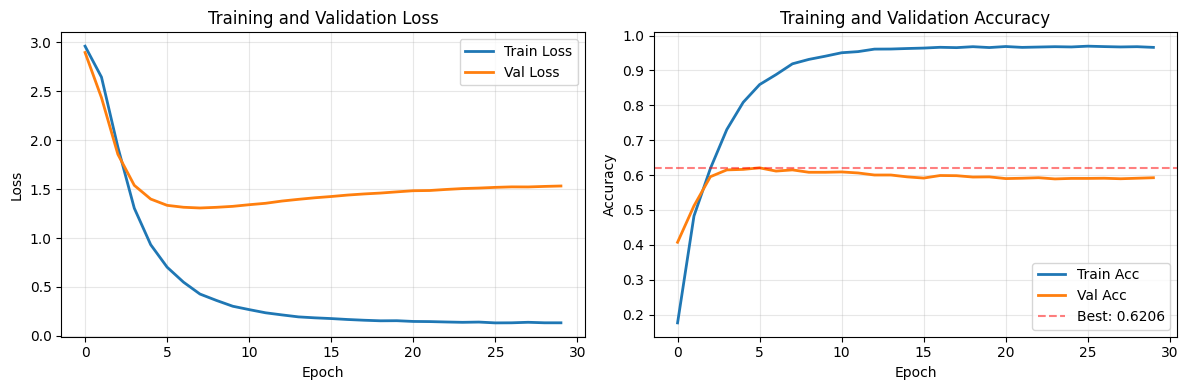

  Class 0 accuracy: 0.3165 (79 samples)
  Class 1 accuracy: 0.6698 (106 samples)
  Class 2 accuracy: 0.6436 (101 samples)
  Class 3 accuracy: 0.5372 (121 samples)
  Class 4 accuracy: 0.5364 (110 samples)
  Class 5 accuracy: 0.5741 (108 samples)
  Class 6 accuracy: 0.6667 (96 samples)
  Class 7 accuracy: 0.7292 (96 samples)
  Class 8 accuracy: 0.6000 (105 samples)
  Class 9 accuracy: 0.7193 (114 samples)
  Class 10 accuracy: 0.8393 (112 samples)
  Class 11 accuracy: 0.5577 (104 samples)
  Class 12 accuracy: 0.5312 (96 samples)
  Class 13 accuracy: 0.5773 (97 samples)
  Class 14 accuracy: 0.6637 (113 samples)
  Class 15 accuracy: 0.7157 (102 samples)
  Class 16 accuracy: 0.5100 (100 samples)
  Class 17 accuracy: 0.7113 (97 samples)
  Class 18 accuracy: 0.2727 (77 samples)
  Class 19 accuracy: 0.1818 (66 samples)

Final Results:
  Validation Accuracy: 0.5930
  Average Class Accuracy: 0.5777


In [1]:
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from jungrad import tensor, no_grad, clip_grad_norm_
from jungrad.nn import Linear, Sequential, ReLU, Dropout
from jungrad.nn.init import kaiming_normal_
from jungrad.nn.utils import count_params
from jungrad.losses import cross_entropy
from jungrad.optim import Adam
from jungrad.sched import CosineLR
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# 1. Load 20 Newsgroups and Create TF-IDF Features
# ============================================================================
np.random.seed(42)
MAX_TRAIN = 4000
MAX_VAL = 2000
MAX_FEATURES = 5000

ds = load_dataset("SetFit/20_newsgroups")

train_texts = ds["train"]["text"][:MAX_TRAIN]
train_labels = np.array(ds["train"]["label"][:MAX_TRAIN], dtype=np.int64)
val_texts = ds["test"]["text"][:MAX_VAL]
val_labels = np.array(ds["test"]["label"][:MAX_VAL], dtype=np.int64)

vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    stop_words="english",
    dtype=np.float32,
    max_df=0.95,
)
train_sparse = vectorizer.fit_transform(train_texts)
val_sparse = vectorizer.transform(val_texts)
X_train = train_sparse.toarray().astype(np.float32)
X_val = val_sparse.toarray().astype(np.float32)

num_classes = len(set(train_labels) | set(val_labels))

print("Dataset: SetFit/20_newsgroups")
print(f"  Train samples (used): {len(train_labels)} / {len(ds['train'])}")
print(f"  Validation samples (used): {len(val_labels)} / {len(ds['test'])}")
print(f"  Features (TF-IDF): {X_train.shape[1]}")
print(f"  Classes: {num_classes}")

# ============================================================================
# 2. Build Model Architecture
# ============================================================================
classifier = Sequential(
    Linear(X_train.shape[1], 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 128),
    ReLU(),
    Dropout(0.3),
    Linear(128, num_classes),
)


def init_modules(module):
    """Recursively initialize Linear layers."""
    if isinstance(module, Linear):
        params = dict(module.named_parameters(recurse=False))
        weight = params.get("weight")
        if weight is not None:
            kaiming_normal_(weight)
        bias = params.get("bias")
        if bias is not None:
            bias.data.fill(0.0)
    for submodule in module._modules.values():
        init_modules(submodule)


init_modules(classifier)

print("\nModel Architecture:")
print(f"  Parameters: {count_params(classifier):,}")
print(f"  Model: {classifier}")

# ============================================================================
# 3. Setup Training Components
# ============================================================================
optimizer = Adam(classifier.parameters(), lr=4e-4, weight_decay=5e-5)
scheduler = CosineLR(optimizer, T_max=40, eta_min=1e-5)

batch_size = 64
num_epochs = 30
grad_clip_value = 1.0

# ============================================================================
# 4. Training Loop with Metrics Tracking
# ============================================================================

def compute_accuracy(logits, labels):
    predictions = np.argmax(logits.data, axis=1)
    return np.mean(predictions == labels)


def train_epoch(model, X, y, batch_size, optimizer):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for start in range(0, len(X), batch_size):
        end = start + batch_size
        batch_X = X[start:end]
        batch_y = y[start:end]

        x_tensor = tensor(batch_X)
        logits = model(x_tensor)
        loss = cross_entropy(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=grad_clip_value)
        optimizer.step()

        total_loss += loss.item()
        total_acc += compute_accuracy(logits, batch_y)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches


def validate(model, X, y, batch_size):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    with no_grad():
        for start in range(0, len(X), batch_size):
            end = start + batch_size
            batch_X = X[start:end]
            batch_y = y[start:end]

            x_tensor = tensor(batch_X)
            logits = model(x_tensor)
            loss = cross_entropy(logits, batch_y)

            total_loss += loss.item()
            total_acc += compute_accuracy(logits, batch_y)
            n_batches += 1

    return total_loss / n_batches, total_acc / n_batches


train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0
best_epoch = 0

print("\nStarting Training...")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: {optimizer.lr}")
print(f"  Gradient clipping: {grad_clip_value}")
print("-" * 60)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(classifier, X_train, train_labels, batch_size, optimizer)
    val_loss, val_acc = validate(classifier, X_val, val_labels, batch_size)

    scheduler.step()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(
            f"Epoch {epoch+1:3d}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
            f"LR: {scheduler.get_lr():.6f}"
        )

print("-" * 60)
print("Training Complete!")
print(f"  Best validation accuracy: {best_val_acc:.4f} (epoch {best_epoch+1})")

# ============================================================================
# 5. Visualize Training Curves
# ============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(train_losses, label="Train Loss", linewidth=2)
ax1.plot(val_losses, label="Val Loss", linewidth=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(train_accs, label="Train Acc", linewidth=2)
ax2.plot(val_accs, label="Val Acc", linewidth=2)
ax2.axhline(y=best_val_acc, color="r", linestyle="--", alpha=0.5, label=f"Best: {best_val_acc:.4f}")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 6. Final Evaluation
# ============================================================================
classifier.eval()
with no_grad():
    val_logits = []
    for start in range(0, len(X_val), batch_size):
        end = start + batch_size
        batch_X = X_val[start:end]
        x_tensor = tensor(batch_X)
        logits = classifier(x_tensor)
        val_logits.append(logits.data)

    val_logits = np.vstack(val_logits)
    val_predictions = np.argmax(val_logits, axis=1)
    final_val_acc = np.mean(val_predictions == val_labels)

    class_accs = []
    for class_idx in range(num_classes):
        mask = val_labels == class_idx
        if mask.sum() > 0:
            class_acc = np.mean(val_predictions[mask] == val_labels[mask])
            class_accs.append(class_acc)
            print(f"  Class {class_idx} accuracy: {class_acc:.4f} ({mask.sum()} samples)")

print("\nFinal Results:")
print(f"  Validation Accuracy: {final_val_acc:.4f}")
print(f"  Average Class Accuracy: {np.mean(class_accs):.4f}")


## Next Steps

Congratulations! You've completed the comprehensive JunGrad tutorial, including training a real-world classifier on the 20 Newsgroups dataset. Here's what you've learned and where to go next:

**🎯 Key Concepts Covered:**
- ✅ N-D Tensors with automatic differentiation
- ✅ Broadcasting and matrix operations
- ✅ Building neural networks with Sequential
- ✅ Training with optimizers (SGD, Adam, AdamW, RMSProp)
- ✅ Advanced layers (Conv1d, LayerNorm, Embedding, Dropout)
- ✅ Activation functions (ReLU, Tanh, Sigmoid, GELU, Softmax)
- ✅ Loss functions (MSE, Cross-entropy, BCE with logits)
- ✅ Learning rate schedulers (StepLR, CosineLR, OneCycleLR)
- ✅ Gradient clipping (by norm and by value)
- ✅ no_grad context manager for inference
- ✅ Computation graph visualization with Graphviz
- ✅ Performance profiling
- ✅ Gradient checking for verification
- ✅ **End-to-end training pipeline** with real-world data (20 Newsgroups)

**🚀 What's Next:**
- **Experiment with the capstone demo**: Try different architectures, optimizers, or hyperparameters on the 20 Newsgroups dataset
- **Try other datasets**: Load different datasets from Hugging Face and adapt the preprocessing pipeline
- **Build your own models**: Combine different layers to create custom architectures for your specific tasks
- **Implement custom layers**: Extend `Module` to create your own specialized layers
- **Explore different optimizers**: Compare Adam, AdamW, and RMSProp on your tasks
- **Visualize your models**: Use Graphviz to understand computation graphs and debug issues
- **Profile performance**: Use the profiler to identify bottlenecks and optimize slow operations
- **Experiment with regularization**: Try different dropout rates, weight decay values, or add batch normalization
- **Explore the full API**: Check the [README](README.md) and [documentation.md](documentation.md) for complete documentation

**📚 Additional Resources:**
- Check `documentation.md` for detailed codebase walkthrough
- Review test files in `tests/` for usage examples
- Explore the source code to understand implementation details
- Visit the [20 Newsgroups dataset page](https://huggingface.co/datasets/SetFit/20_newsgroups) to learn more about the data

**💡 Tips for Going Further:**
- Modify the capstone demo to use different feature extraction methods (e.g., word embeddings, character-level features)
- Experiment with different model architectures (deeper networks, wider layers, residual connections)
- Try implementing early stopping based on validation accuracy
- Add data augmentation or preprocessing techniques specific to your domain

Happy coding! 🎉